<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/Homework4_JoelB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 OPTI 556

### Joel Berkson 11/2/2021

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist

#### Holography

Angular Spectrum Function

In [2]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
  # Pad input field with zeros so that output sampling is same
  zPad=np.int(np.abs(d*lam))
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

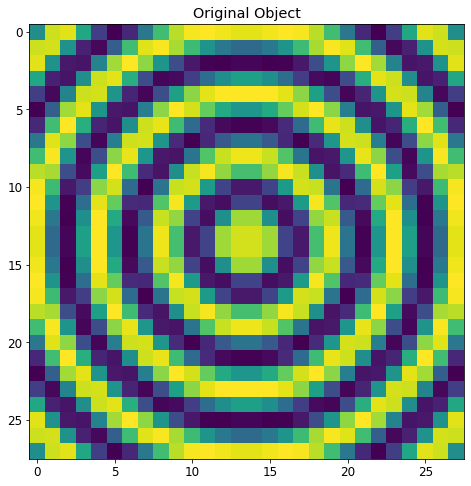

In [3]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 12})
X = np.linspace(-1,1,28)
Y = X
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2+Y**2)
Fringe = np.sin((R)*20)
plt.imshow(Fringe)
plt.title('Original Object')
r=1
N=512
theta=np.pi/50
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo_offaxis=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
holo_inline=np.abs(q +r)**2


659344
1236544


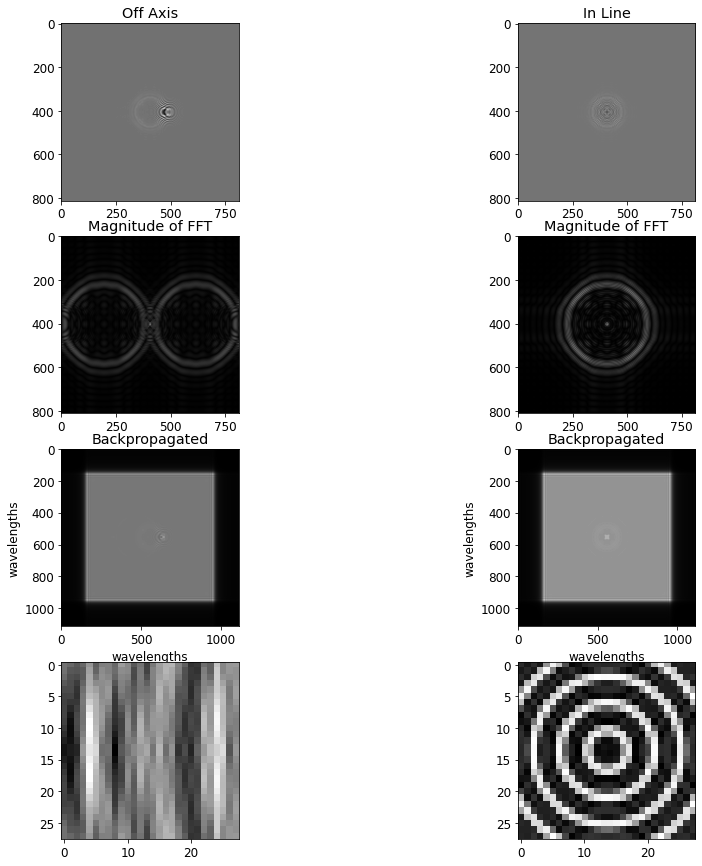

In [4]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(4,2,1)
plt.imshow(holo_offaxis-r**2, cmap='gray', aspect='equal')
plt.title('Off Axis')
plt.subplot(4,2,2)
plt.title('In Line')
plt.imshow(holo_inline-r**2, cmap='gray', aspect='equal')
plt.subplot(4,2,3)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(holo_offaxis-r**2))),cmap='gray', aspect='equal')
plt.title('Magnitude of FFT')
plt.subplot(4,2,4)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(holo_inline-r**2))),cmap='gray', aspect='equal')
plt.title('Magnitude of FFT')
plt.subplot(4,2,5)
plt.imshow(np.abs(g(holo_offaxis,-d,lam)),cmap='gray', aspect='equal')
plt.title('Backpropagated')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,2,6)
plt.imshow(np.abs(g(holo_inline,-d,lam)),cmap='gray', aspect='equal')
plt.title('Backpropagated')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,2,7)
print(np.size(holo_offaxis))
plt.imshow(np.abs(g(holo_offaxis,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')
plt.subplot(4,2,8)
print(np.size(np.abs(g(holo_inline,-d,lam))))
plt.imshow(np.abs(g(holo_inline,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')

Clearly for both methods, phase is completely lost (since detectors only record amplitude), however the off axis reference plane wave does a better job at recovering it (with some residual tilt fringes). Let try the random reference signal

(-0.5, 27.5, 27.5, -0.5)

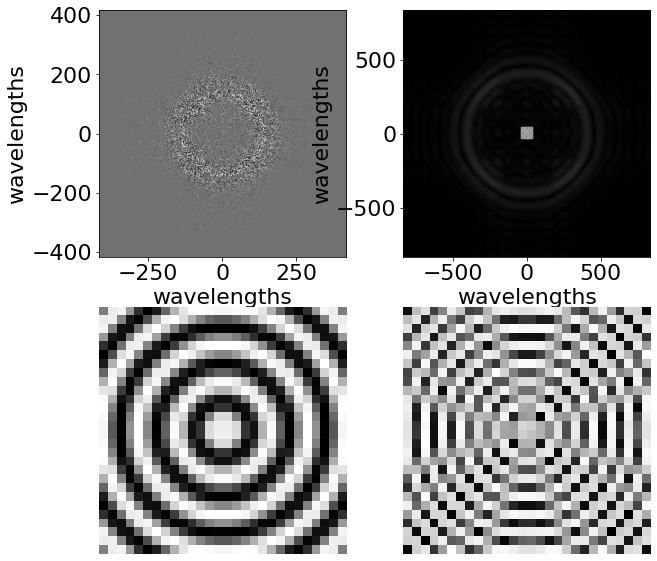

In [5]:
# diffracted field
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=np.pi/50
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
reference=np.exp(np.pi*1j*np.random.randint(2,size=q.shape))
holo=np.abs(q +reference)**2
plt.subplot(2,2,1)
hS=holo.shape[0]/4
plt.imshow(holo[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,2)
pip=g(reference*(holo-1),-d,lam)
xrange=d/lam
hS=pip.shape[0]/4
plt.imshow(np.abs(pip)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,3)
plt.imshow(Fringe,cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.abs(pip[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')

Overall this is much better, but there is still some phase issues which almost look like aliasing in the reconstructed image. Next is the Gabor Hologram, which should do an even better job.

Text(0, 0.5, 'wavelengths')

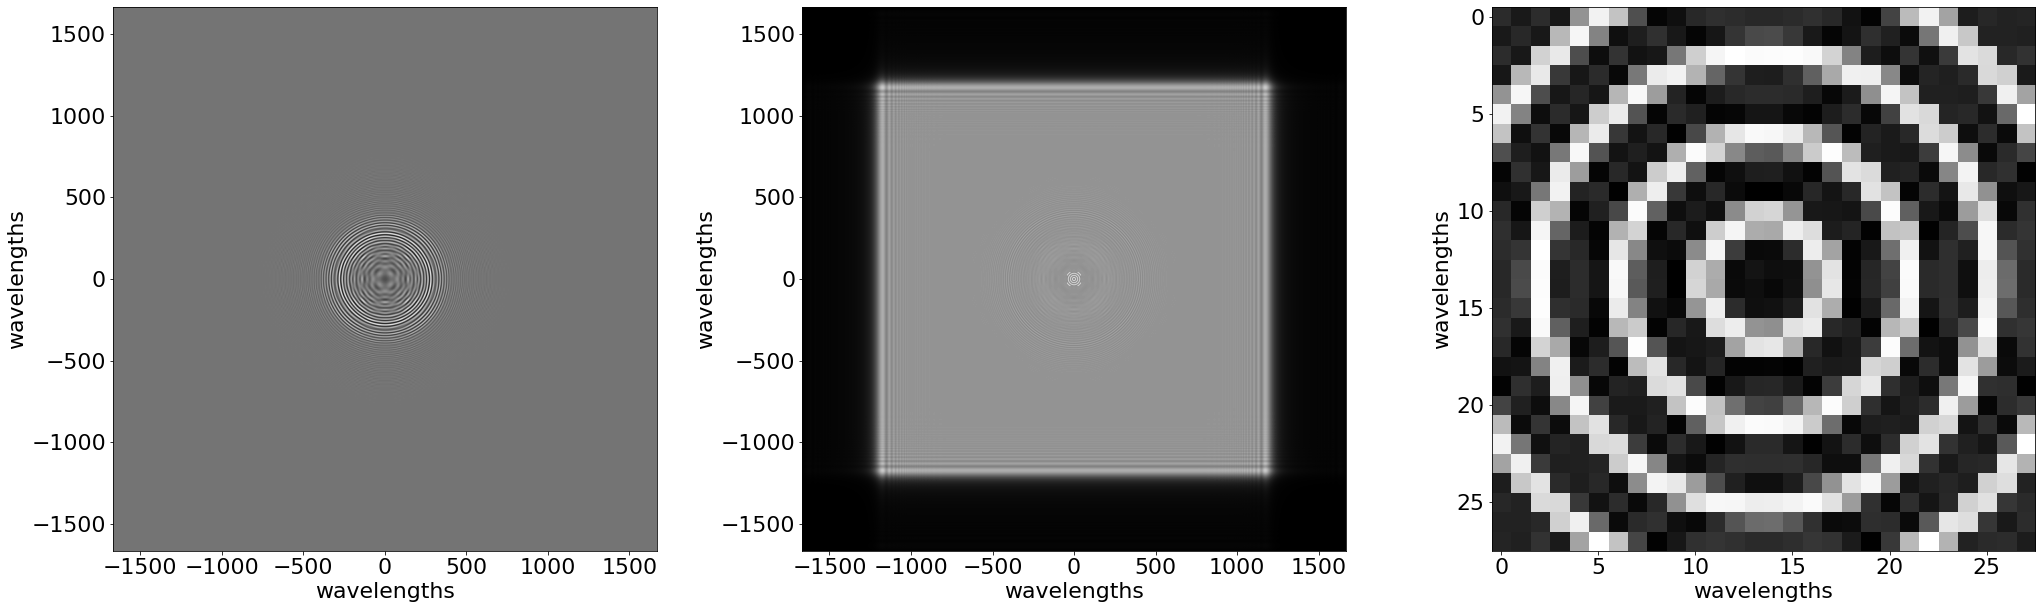

In [ ]:

# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=0
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=Fringe
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
plt.subplot(1,3,1)
plt.imshow(holo-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,2)
plt.imshow(np.abs(g(holo,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,3)
plt.imshow(np.abs(g(holo,-d,lam)[542:570,542:570]),cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Clearly the reconstruction is much better, but has some speckle due to the introduction of random phase(See speckle below)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


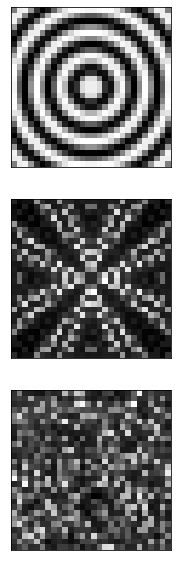

In [ ]:

# diffracted field
plt.figure(figsize=(20, 10))
r=1
N=512
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths

ax = plt.subplot(3, 1, 1)
plt.imshow(Fringe.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 2)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*Fringe)
q=g(f,d,lam)
holo=np.abs(q +r)**2
plt.imshow(np.abs(g(holo,-d,lam))[542:570,542:570])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 3)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*Fringe
q=g(f,d,lam)
holo=np.abs(q +r)**2
plt.imshow(np.abs(g(holo,-d,lam)[542:570,542:570]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Now to try a neural estimator for multiplane objects. I am thinking I will do it like this:
There will be 4 possible planes for the object to exist in each sepated by d=100(to save computing time). This will make it so that the training data output is 28x28x4, and the input data will simply be the sum of each hologram (in reality, the field scattered from the first plane would hit the next plane, and then the next etc. but this sounds too complicated for now)


In [46]:
def gp(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
  # Pad input field with zeros so that output sampling is same
  zPad=np.int(np.abs(d*lam))
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

In [156]:
# load the mnist dataset of characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
print(np.shape(x_train))
x_test = x_test[0:400]
y_test = y_test[0:400]
x_train = x_train[0:400]
y_train = y_train[0:400]
N=512
f1=np.zeros([N,N]).astype('complex128')
f2=np.zeros([N,N]).astype('complex128')
f3=np.zeros([N,N]).astype('complex128')
f4=np.zeros([N,N]).astype('complex128')
x_trainstacked = np.zeros([len(x_test)//4,4,28,28])
x_teststacked = np.zeros([len(x_test)//4,4,28,28])
holo = np.zeros([N,N])
#
# holographic recordin parameters
r=1
N=512
lam=.3 # ratio of wavelength to the sampling period
d=[700,800,900,1000]
g_test=np.zeros((len(x_test)//4,28,28,8)).astype('complex128')
g_train=np.zeros((len(x_train)//4,28,28,8)).astype('complex128')

# generation of test inputs
for pop in range(0,np.shape(x_test)[0],4):

  f1[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_train[pop,:,:]
  f2[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_train[pop+1,:,:]
  f3[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_train[pop+2,:,:]
  f4[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_train[pop+3,:,:]
  q1=gp(f1,d[0],lam)
  q2=gp(f2,d[1],lam)[15:-15,15:-15]
  q3=gp(f3,d[2],lam)[30:-30,30:-30]
  q4=gp(f4,d[3],lam)[45:-45,45:-45]
  holo=np.abs(q1+q2+q3+q4 +r)**2
 
  
  iq1=gp(holo,-d[0],lam)[452:480,452:480]
  iq1=iq1/np.max(np.abs(iq1))

  iq2=gp(holo,-d[1],lam)[452+15:480+15,452+15:480+15]
  iq2=iq2/np.max(np.abs(iq2))

  iq3=gp(holo,-d[2],lam)[452+30:480+30,452+30:480+30]
  iq3=iq3/np.max(np.abs(iq3))

  iq4=gp(holo,-d[3],lam)[452+45:480+45,452+45:480+45]
  iq4=iq4/np.max(np.abs(iq4))
  


  g_train[pop//4,:,:,0]=(1+np.real(iq1))/2
  g_train[pop//4,:,:,1]=(1+np.imag(iq1))/2
  
  g_train[pop//4,:,:,2]=(1+np.real(iq2))/2
  g_train[pop//4,:,:,3]=(1+np.imag(iq2))/2
  
  g_train[pop//4,:,:,4]=(1+np.real(iq3))/2
  g_train[pop//4,:,:,5]=(1+np.imag(iq3))/2
  
  g_train[pop//4,:,:,6]=(1+np.real(iq4))/2
  g_train[pop//4,:,:,7]=(1+np.imag(iq4))/2
  x_trainstacked[pop//4,:,:,:] = x_train[pop:pop+4,:,:]
# generation of training inputs
for pop in range(0,np.shape(x_test)[0],4):
  f1[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[pop,:,:]
  f2[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[pop+1,:,:]
  f3[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[pop+2,:,:]
  f4[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[pop+3,:,:]
  q1=gp(f1,d[0],lam)
  q2=gp(f2,d[1],lam)[15:-15,15:-15]
  q3=gp(f3,d[2],lam)[30:-30,30:-30]
  q4=gp(f4,d[3],lam)[45:-45,45:-45]

  holo=np.abs(q1+q2+q3+q4 +r)**2
 
  
  iq1=gp(holo,-d[0],lam)[452:480,452:480]
  iq1=iq1/np.max(np.abs(iq1))

  iq2=gp(holo,-d[1],lam)[452+15:480+15,452+15:480+15]
  iq2=iq2/np.max(np.abs(iq2))

  iq3=gp(holo,-d[2],lam)[452+30:480+30,452+30:480+30]
  iq3=iq3/np.max(np.abs(iq3))

  iq4=gp(holo,-d[3],lam)[452+45:480+45,452+45:480+45]
  iq4=iq4/np.max(np.abs(iq4))
  


  g_test[pop//4,:,:,0]=(1+np.real(iq1))/2
  g_test[pop//4,:,:,1]=(1+np.imag(iq1))/2
  
  g_test[pop//4,:,:,2]=(1+np.real(iq2))/2
  g_test[pop//4,:,:,3]=(1+np.imag(iq2))/2
  
  g_test[pop//4,:,:,4]=(1+np.real(iq3))/2
  g_test[pop//4,:,:,5]=(1+np.imag(iq3))/2
  
  g_test[pop//4,:,:,6]=(1+np.real(iq4))/2
  g_test[pop//4,:,:,7]=(1+np.imag(iq4))/2
  x_teststacked[pop//4,:,:,:] = x_test[pop:pop+4,:,:]

x_train = np.transpose(x_trainstacked,(0,2,3,1))
x_test = np.transpose(x_teststacked,(0,2,3,1))

(60000, 28, 28)


In [133]:
inputs=keras.Input(shape=(28,28,8))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (4, 4), strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (2, 2), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (2, 2), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), activation="linear", padding="same")(x)


gaborEstimator = keras.Model(inputs, x)
gaborEstimator.compile(optimizer='adam', loss='mean_squared_error')
gaborEstimator.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 8)]       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 32)        6432      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 128)       131200    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
conv2d_transpose_87 (Conv2DT (None, 14, 14, 64)        164

In [157]:

gaborEstimator.fit(
    x=g_train,
    y=x_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/20
2/2 [==============================] - 1s 584ms/step - loss: 0.0667 - val_loss: 0.0673
Epoch 2/20
2/2 [==============================] - 1s 543ms/step - loss: 0.0663 - val_loss: 0.0669
Epoch 3/20
2/2 [==============================] - 1s 544ms/step - loss: 0.0656 - val_loss: 0.0668
Epoch 4/20
2/2 [==============================] - 1s 543ms/step - loss: 0.0654 - val_loss: 0.0657
Epoch 5/20
2/2 [==============================] - 1s 539ms/step - loss: 0.0652 - val_loss: 0.0653
Epoch 6/20
2/2 [==============================] - 1s 544ms/step - loss: 0.0650 - val_loss: 0.0655
Epoch 7/20
2/2 [==============================] - 1s 552ms/step - loss: 0.0647 - val_loss: 0.0649
Epoch 8/20
2/2 [==============================] - 1s 551ms/step - loss: 0.0645 - val_loss: 0.0648
Epoch 9/20
2/2 [==============================] - 1s 549ms/step - loss: 0.0642 - val_loss: 0.0649
Epoch 10/20
2/2 [==============================] - 1s 554ms/step - loss: 0.0641 - val_loss: 0.0645
Epoch 11/20
2/2 [==

(1, 28, 28, 4)


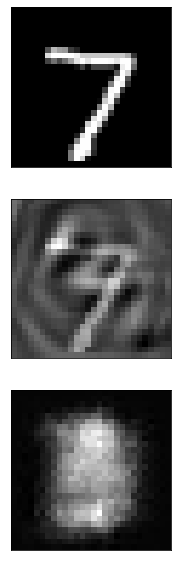

In [158]:
print(np.shape(gaborEstimator.predict(g_test[0:1,:,:,0:8])))
n = 5

ax = plt.subplot(3, 1, 1)
plt.imshow(x_test[0,:,:,0])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 2)
plt.imshow(np.real(g_test[0,:,:,0]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(3, 1, 3)
plt.imshow(gaborEstimator.predict(g_test[0:1,:,:,0:8])[0,:,:,0])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Part 2: Fourier Ptychography